# Multiclass classification

## Import libraries

In [1]:
import torch 
import torch.nn as nn
import torchmetrics
from torch.utils.data import Dataset
import pandas as pd
import wandb

## Config

In [2]:
import torch.nn as nn 
import numpy as np

torch.manual_seed(42)

np.random.seed(42)

BATCH_SIZE = 32
LR = 0.001
CLASSES = 6

TRAIN_VAL_TEST_SPLIT = [0.7, 0.15, 0.15]

MAX_EPOCHS = 100

LOSS_WEIGHTS = [4.0,4.0,2.0,3.0,5.0,5.0]
LOSS_FUNCTION =nn.CrossEntropyLoss(weight=torch.tensor(LOSS_WEIGHTS))#weight=torch.tensor([2.0, 1.0,3.0,4.0,8.0,4.0]

DROPOUT_COEF = 0.35


SAVE_BEST_MODEL = True
IS_MULTICLASS = True if CLASSES > 2 else False
NUM_OF_WORKERS = 0

REDUCE_LR_PATIENCE = 10
EARLY_STOPPING_PATIENCE = 20


## WANDB Init

In [ ]:


wandb.init(project="zneus-project-1-multiclass", name="Basic model with higher amount of neurons")

# Config hyperparameters
config = wandb.config

config.batch_size = BATCH_SIZE
config.learning_rate = LR
config.max_epochs = MAX_EPOCHS
config.dropout_coef = DROPOUT_COEF
config.desc = "MLP: (1024, BatchNorm,ReLU,Dropout) (512,BatchNorm, ReLU,Dropout) (256,BatchNorm, ReLU, Dropout) (1)"
config.loss_function = "BinaryCrossentropy with logits"
config.reduce_lr_patience = REDUCE_LR_PATIENCE
config.early_stopping_patience = EARLY_STOPPING_PATIENCE
config.loss_weights = LOSS_WEIGHTS


'\nwandb.init(project="zneus-project-1-multiclass", name="Basic model with higher amount of neurons")\n\n# Config hyperparameters\nconfig = wandb.config\n\nconfig.batch_size = BATCH_SIZE\nconfig.learning_rate = LR\nconfig.max_epochs = MAX_EPOCHS\nconfig.dropout_coef = DROPOUT_COEF\nconfig.desc = "MLP: (1024, BatchNorm,ReLU,Dropout) (512,BatchNorm, ReLU,Dropout) (256,BatchNorm, ReLU, Dropout) (1)"\nconfig.loss_function = "BinaryCrossentropy with logits"\nconfig.reduce_lr_patience = REDUCE_LR_PATIENCE\nconfig.early_stopping_patience = EARLY_STOPPING_PATIENCE\nconfig.loss_weights = LOSS_WEIGHTS\n'

## Define Dataset

In [4]:

class SteelPlateDataset(Dataset):

    def __init__(self, dataset_path):
        super().__init__()
        self.path = dataset_path
        self.df = pd.read_csv(self.path)

        self.features = self.df.drop(["Class", *("Pastry Z_Scratch K_Scratch Stains Dirtiness Bumps".split(" "))] ,axis= 1).values.tolist() # V28 V29 V30 V31 V32 V33
        self.labels =  self.df[[*"Pastry Z_Scratch K_Scratch Stains Dirtiness Bumps".split(" ")]].dot([i for i in range(6)]).values.tolist() # V28 V29 V30 V31 V32 V33
       
    def __getitem__(self, index):

        return torch.tensor(self.features[index]), torch.tensor(self.labels[index]).float()

    def __len__(self):
        return len(self.labels)
        


## Create datasets

In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset

dataset = SteelPlateDataset("data/norm_multiclass_data.csv")

labels = np.array(dataset.labels)
print(labels)
train_size, val_size, test_size = TRAIN_VAL_TEST_SPLIT

train_val_indices, test_indices = train_test_split(
    range(len(dataset)),
    test_size=TRAIN_VAL_TEST_SPLIT[1],
    stratify=dataset.labels,
    random_state=42
)

# Update labels for train+val indices
train_val_labels = labels[train_val_indices]

# Second split: train vs val
train_indices, val_indices = train_test_split(
    train_val_indices,
    test_size=val_size / (train_size + val_size),  # Adjust proportion for train+val
    stratify=train_val_labels,
    random_state=42
)



train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)


[0 0 0 ... 0 0 0]


## Define device

In [6]:
if torch.cuda.is_available():
    device_name = "cuda"
elif torch.backends.mps.is_available():
    device_name = "mps"
else:
    device_name = "cpu"

## Create dataloaders

In [7]:
from torch.utils.data import DataLoader



train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    
    shuffle=True,  # Default shuffling for training
    num_workers=NUM_OF_WORKERS
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No shuffling for validation
    num_workers=NUM_OF_WORKERS
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No shuffling for test
    num_workers=NUM_OF_WORKERS
)

# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 1129
Validation dataset size: 242
Test dataset size: 242


## Define EarlyStopping class

In [8]:
import torch

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            min_delta (float): Minimum change to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


## Define model

In [ ]:
from torchmetrics.classification import Accuracy, Precision
from torch.optim.lr_scheduler import ReduceLROnPlateau


class MyModel(nn.Module):
    def __init__(self, input_size,lr=0.001, loss_fn=nn.BCELoss(), num_classes=2,reduce_lr_patience=10, early_stopping_patience=10):
        super().__init__()
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes,average="macro")
        self.precision = Precision(task="multiclass", num_classes=num_classes, average="macro")
        self.loss_fn = loss_fn


        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(DROPOUT_COEF),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(DROPOUT_COEF),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(DROPOUT_COEF),

      

            nn.Linear(128, num_classes)
        )
        self.to(device_name)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        self.early_stopping = EarlyStopping(patience=early_stopping_patience, min_delta=0.01)

        self.scheduler = ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=reduce_lr_patience
        )

    def forward(self, x):
        return self.model(x)
        
        
    def evaluate(self, dataloader):
        self.eval()
        eval_loss = 0

        self.precision.reset()
        self.accuracy.reset()

        

        with torch.no_grad():
            for batch in dataloader:

                x = batch[0].to(device_name)
                y = batch[1].to(device_name)

                output = self.forward(x)
                output = torch.sigmoid(output).squeeze(1)
                y = y.float()

                
                    
                loss = self.loss_fn(output, y)
 
                self.accuracy(output, y)
                self.precision(output, y)
              
          
                eval_loss += loss.item()

        self.train()
        return (eval_loss/len(dataloader), self.accuracy.compute(), self.precision.compute())
    
        
    def fit(self, train_dataloader, val_dataloader, epochs=10):
        self.train()
        best_val_loss = 9999

     
      
        for i in range(0,epochs):
           
            self.accuracy.reset()
            epoch_loss = 0
            for batch in train_dataloader:

                x = batch[0].to(device_name)
                y = batch[1].to(device_name)
              

                output = self.forward(x)
                output = torch.sigmoid(output).squeeze(1)
                y = y.float()
                
            
                
                loss = self.loss_fn(output, y)

               
                self.accuracy(output, y)
                self.precision(output, y)

                epoch_loss += loss.item()

                self.zero_grad()
                loss.backward()
                self.optimizer.step()


            epoch_loss/=len(train_dataloader)
           
            epoch_acc = self.accuracy.compute()
            epoch_precision = self.precision.compute()

       

            val_loss, val_acc, val_precision = self.evaluate(val_dataloader)
            if best_val_loss > val_loss:
                best_val_loss = val_loss
                torch.save(self.state_dict(), "best-model-multiclass.pth")


            self.scheduler.step(val_loss)
            wandb.log({"epoch": i, "Train Loss": epoch_loss, "Train Acc":epoch_acc,"Train Precision":epoch_precision, "Val Loss":val_loss, "Val Acc":val_acc,"Val Precision":val_precision, "LR":self.optimizer.param_groups[0]['lr']})
            print(f"Epoch {i+1} Loss:{epoch_loss:.4f} Accuracy:{epoch_acc:.4f} Precision:{epoch_precision:.4f} Val Loss:{val_loss:.4f} Val Accuracy:{val_acc:.4f} Val Precision:{val_precision:.4f} LR = {self.optimizer.param_groups[0]['lr']}")
            self.early_stopping(val_loss)
            if self.early_stopping.early_stop:
                print("Early stopping")
                break
        wandb.finish()
        


## Create model

In [10]:
model = MyModel(
    input_size=len(dataset.features[0]),
    num_classes=CLASSES, 
    loss_fn=LOSS_FUNCTION, lr=LR, 
    reduce_lr_patience=REDUCE_LR_PATIENCE, 
    early_stopping_patience=EARLY_STOPPING_PATIENCE
)

## Train model

In [11]:
model.fit(train_dataloader, val_dataloader, epochs=MAX_EPOCHS)

Epoch 1 Loss:1.5967 Accuracy:0.4945 Precision:0.4459 Val Loss:1.4830 Val Accuracy:0.5605 Val Precision:0.5862 LR = 0.001
Epoch 2 Loss:1.4091 Accuracy:0.4851 Precision:0.6044 Val Loss:1.3765 Val Accuracy:0.5742 Val Precision:0.6283 LR = 0.001
Epoch 3 Loss:1.3436 Accuracy:0.5435 Precision:0.6493 Val Loss:1.3308 Val Accuracy:0.6310 Val Precision:0.6404 LR = 0.001
Epoch 4 Loss:1.3092 Accuracy:0.6271 Precision:0.6611 Val Loss:1.3044 Val Accuracy:0.6447 Val Precision:0.6282 LR = 0.001
Epoch 5 Loss:1.2875 Accuracy:0.6594 Precision:0.6708 Val Loss:1.2955 Val Accuracy:0.6652 Val Precision:0.6433 LR = 0.001
Epoch 6 Loss:1.2728 Accuracy:0.6776 Precision:0.6771 Val Loss:1.2829 Val Accuracy:0.6570 Val Precision:0.6536 LR = 0.001
Epoch 7 Loss:1.2632 Accuracy:0.6880 Precision:0.6814 Val Loss:1.2806 Val Accuracy:0.6638 Val Precision:0.6599 LR = 0.001
Epoch 8 Loss:1.2529 Accuracy:0.6909 Precision:0.6810 Val Loss:1.2727 Val Accuracy:0.6650 Val Precision:0.6529 LR = 0.001
Epoch 9 Loss:1.2445 Accuracy:0.6

In [12]:
val_loss, val_acc, val_precision = model.evaluate(val_dataloader)
print(f"Test Loss:{val_loss} Test Accuracy:{val_acc.item()} Test Precision:{val_precision.item()}")

Test Loss:1.253436490893364 Test Accuracy:0.7837744951248169 Test Precision:0.8430511355400085


## Confusion Matrix on validation set 

[[80  2  0  3  0 25]
 [ 7 19  0  0  0  2]
 [ 0  0 26  0  0  0]
 [ 0  0  0 10  0  1]
 [ 1  0  0  0  5  2]
 [14  0  0  0  0 45]]


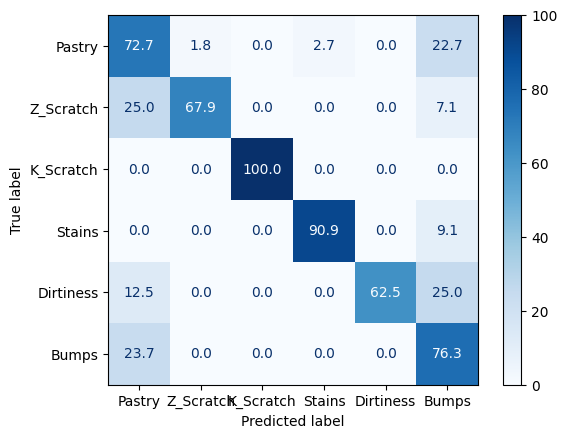

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example data (each pixel has an integer class label)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=len(val_dataset),
    shuffle=False,  # Use sampler instead of shuffle
    num_workers=NUM_OF_WORKERS
)

features, ground_truth = next(iter(val_dataloader))

images = features.to(device_name)
model.eval()
predictions = model(images)

predictions =  torch.argmax(predictions, dim=1).float()
y_true = ground_truth.numpy()
y_pred = predictions.detach().cpu().int().numpy()

y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

cm = confusion_matrix(y_true_flat, y_pred_flat, labels=[0, 1, 2,3,4,5])
print(cm)
# Convert to percentage (%)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent,
                          display_labels=["Pastry", "Z_Scratch","K_Scratch"	,"Stains"	,"Dirtiness"	,"Bumps"])

disp.plot(cmap='Blues', values_format='.1f')



## Load the best model by loss

In [14]:
model.load_state_dict(torch.load("best-model-multiclass.pth", map_location=device_name))

<All keys matched successfully>

## Confusion Matrix on validation set 

[[80  3  0  3  1 23]
 [ 6 21  0  0  0  1]
 [ 0  0 25  1  0  0]
 [ 0  0  0 10  0  1]
 [ 0  0  0  0  6  2]
 [17  1  0  0  0 41]]


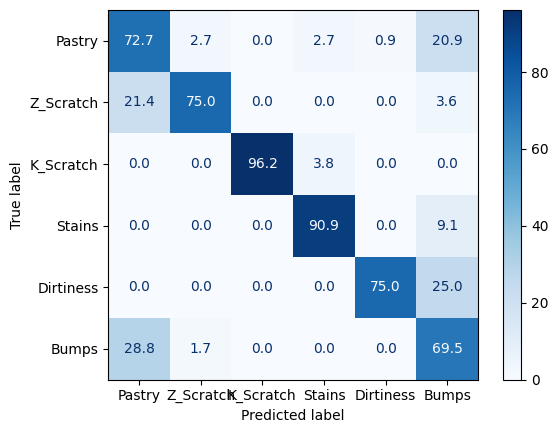

In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example data (each pixel has an integer class label)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=len(val_dataset),
    shuffle=False,  # Use sampler instead of shuffle
    num_workers=NUM_OF_WORKERS
)

features, ground_truth = next(iter(val_dataloader))

images = features.to(device_name)
model.eval()
predictions = model(images)

predictions =  torch.argmax(predictions, dim=1).float()
y_true = ground_truth.numpy()
y_pred = predictions.detach().cpu().int().numpy()

y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

cm = confusion_matrix(y_true_flat, y_pred_flat, labels=[0, 1, 2,3,4,5])
print(cm)
# Convert to percentage (%)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent,
                          display_labels=["Pastry", "Z_Scratch","K_Scratch"	,"Stains"	,"Dirtiness"	,"Bumps"])



disp.plot(cmap='Blues', values_format='.1f')



## Test on the test set (only for final evaluation)

### Test set class distribution

In [16]:
from collections import Counter

labels = [label.item() for _, label in test_dataset]
class_counts = Counter(labels)

print("\nClass Distribution:")
print("-" * 30)
class_names = ["Pastry", "Z_Scratch","K_Scratch"	,"Stains"	,"Dirtiness"	,"Bumps"]
for cls, count in sorted(class_counts.items()):
    print(f"Class {class_names[int(cls)]} | Count: {count}")
print("-" * 30)



Class Distribution:
------------------------------
Class Pastry | Count: 110
Class Z_Scratch | Count: 28
Class K_Scratch | Count: 26
Class Stains | Count: 11
Class Dirtiness | Count: 8
Class Bumps | Count: 59
------------------------------


In [18]:
test_loss, test_acc, test_precision = model.evaluate(test_dataloader)
print(f"Test Loss:{test_loss} Test Accuracy:{test_acc.item()} Test Precision:{test_precision.item()}")

Test Loss:1.24232979118824 Test Accuracy:0.8337084650993347 Test Precision:0.7915846705436707


### Confusion Matrix

[[77  3  0  1  2 27]
 [ 2 24  0  0  0  2]
 [ 0  0 26  0  0  0]
 [ 0  0  0 10  0  1]
 [ 1  0  0  0  7  0]
 [17  1  0  1  1 39]]


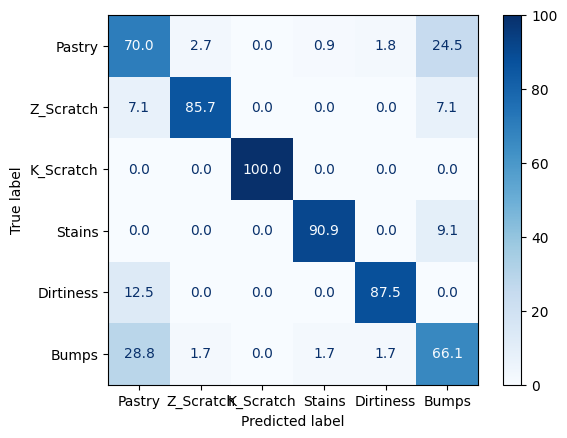

In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example data (each pixel has an integer class label)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=len(test_dataset),
    shuffle=False,  # Use sampler instead of shuffle
    num_workers=NUM_OF_WORKERS
)

features, ground_truth = next(iter(test_dataloader))

images = features.to(device_name)
model.eval()
predictions = model(images)

predictions =  torch.argmax(predictions, dim=1).float()
y_true = ground_truth.numpy()
y_pred = predictions.detach().cpu().int().numpy()

y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

cm = confusion_matrix(y_true_flat, y_pred_flat, labels=[0, 1, 2,3,4,5])
print(cm)
# Convert to percentage (%)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent,
                          display_labels=["Pastry", "Z_Scratch",	"K_Scratch"	,"Stains"	,"Dirtiness"	,"Bumps"])

disp.plot(cmap='Blues', values_format='.1f')




   


